## Setup

In [168]:
# DO NOT ALTER THIS CELL OR ITS TAG (parameters). It is used by papermill to fill in these parameters before executing the notebook.
DATA_PATH = "/home/it1123/dev_local/cse284/snp_clustering/tmp/clustering_pca.eigenvec"
K_HIGH = 14

In [169]:
import os
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt


In [170]:
# set directories
REPO_DIR = os.path.dirname(os.getcwd())
DATA_DIR = os.path.join(REPO_DIR, "data")
OUT_DIR = os.path.join(REPO_DIR, "out")
POPCODES_PATH = os.path.join(DATA_DIR, "igsr_samples.tsv")
RAND_SEED = 256
MARKERS = [
    ".", ",", "o", "v", "^", "<", ">", "1", "2", "3", "4", "8", "s", "p", "P", "*", "h", "H", "+", "x", "X", "D", "d", "|", "_", 
    0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11
]
COLORS = [
    'red', 'blue', 'green', 'cyan', 'magenta', 'yellow', 'black', 'white',
    'gray', 'orange', 'pink', 'brown', 'purple', 'lime', 'olive', 'navy',
    'maroon', 'teal', 'aqua', 'silver', 'gold', 'indigo', 'violet', 'crimson',
    'coral', 'turquoise', 'salmon', 'khaki', 'plum', 'orchid', 'beige', 'mint',
    'lavender'
]

## Data Loading/Preprocessing
We assume the existence of the file containing the coordinates of each sample in the eigenbasis (computed by `plink`)

### Load data & label columns

In [171]:
pca_data = pd.read_csv(DATA_PATH, delim_whitespace=True, header=None)
popcodes_df = pd.read_csv(POPCODES_PATH, sep="\t", header=0)
id_cols = ["family_id", "id"]
pop_cols = ["pop", "subpop"]
pc_cols = [f"pc{i+1}" for i in range(pca_data.shape[1] - 2)]
pca_data.columns =  id_cols + pc_cols

In [172]:
pca_data.head()

,family_id,id,pc1,pc2,pc3,pc4
0,HG00096,HG00096,-0.009763,0.027213,0.013751,0.015727
1,HG00097,HG00097,-0.014707,0.026629,0.011751,0.011084
2,HG00099,HG00099,-0.012137,0.025007,0.008817,0.014421
3,HG00100,HG00100,-0.012606,0.027683,0.014390,0.008601
4,HG00101,HG00101,-0.012874,0.022498,0.017722,0.007210


In [173]:
print (popcodes_df["Superpopulation code"].unique())
print()
print (popcodes_df['Population code'].unique())

['EUR' 'EAS' 'AMR' 'SAS' 'AFR' nan 'EUR,AFR']

['FIN' 'GBR' 'CHS' 'PUR' 'CDX' 'CLM' 'IBS' 'KHV' 'PEL' 'PJL' 'ACB' 'GWD'
 'ESN' 'BEB' 'MSL' 'ITU' 'STU' 'CEU' 'YRI' 'CHB' 'JPT' 'LWK' 'MXL' 'ASW'
 'TSI' 'GIH' 'GWJ' 'GWF' 'GWW' nan 'MKK' 'IBS,MSL']


### Map samples to population/subpopulation codes & get feature matrix $X$

In [174]:
#map samples to populations/subpopulation code
pca_data["pop"] = pca_data["id"].apply(lambda x: popcodes_df.loc[popcodes_df['Sample name'] == x, 'Superpopulation code'].squeeze())
pca_data["subpop"] = pca_data["id"].apply(lambda x: popcodes_df.loc[popcodes_df['Sample name'] == x, 'Population code'].squeeze())

pca_data = pca_data.loc[:, id_cols + pop_cols + pc_cols]
#get feature matrix for clustering
pop_data = pca_data.loc[:, id_cols + pop_cols]
X = pca_data.loc[:, pc_cols].to_numpy()


In [175]:
pop_data.head()

,family_id,id,pop,subpop
0,HG00096,HG00096,EUR,GBR
1,HG00097,HG00097,EUR,GBR
2,HG00099,HG00099,EUR,GBR
3,HG00100,HG00100,EUR,GBR
4,HG00101,HG00101,EUR,GBR


In [176]:
X[:5]

array([[-0.0097632 ,  0.0272129 ,  0.013751  ,  0.0157271 ],
       [-0.0147066 ,  0.0266289 ,  0.0117507 ,  0.0110837 ],
       [-0.0121369 ,  0.0250071 ,  0.00881677,  0.0144206 ],
       [-0.0126055 ,  0.0276831 ,  0.0143899 ,  0.00860087],
       [-0.0128736 ,  0.0224982 ,  0.0177218 ,  0.00721044]])

### create mapping between true population and point shape in clustering

In [177]:
pops_unique = pca_data['pop'].unique()
pop_shapes = dict(zip(pops_unique, MARKERS[:pops_unique.shape[0]]))

In [178]:
subpops_unique = pca_data['subpop'].unique()
subpop_shapes = dict(zip(subpops_unique, MARKERS[:subpops_unique.shape[0]]))
subpop_shapes

{'GBR': '.',
 'FIN': ',',
 'CHS': 'o',
 'PUR': 'v',
 'CDX': '^',
 'CLM': '<',
 'IBS': '>',
 'PEL': '1',
 'PJL': '2',
 'KHV': '3',
 'IBS,MSL': '4',
 'ACB': '8',
 'GWD': 's',
 'ESN': 'p',
 'BEB': 'P',
 'MSL': '*',
 'STU': 'h',
 'ITU': 'H',
 'CEU': '+',
 'YRI': 'x',
 'CHB': 'X',
 'JPT': 'D',
 'LWK': 'd',
 'ASW': '|',
 'MXL': '_',
 'TSI': 0,
 'GIH': 1}

## Clustering
#### Here we cluster the principal component data using $k$-means clustering and hierarchical clustering (Ward's method, agglomerative).

### $k$-Means Clustering

#### Find optimal $k$

In [179]:
# fit K-means, tune k
#silhouette scores as a measure of clustering quality
#sil scores are from -1 to 1
sil_scores = []
K = range(2, K_HIGH)
for k in K:
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=300, random_state=RAND_SEED)
    kmeans.fit(X)
    labels = kmeans.labels_
    sil_scores.append(silhouette_score(X, labels))

sil_scores = np.array(sil_scores)
optimal_k = K[np.argmax(sil_scores)]
kmeans_optimal = KMeans(n_clusters=optimal_k, init='k-means++', n_init=10, max_iter=300, random_state=RAND_SEED)
kmeans_optimal.fit(X)
print (f"optimal k: {optimal_k}; best silhouette score: {np.max(sil_scores)}")

optimal k: 6; best silhouette score: 0.7436697193910644


#### Plot silhouette score vs $k$

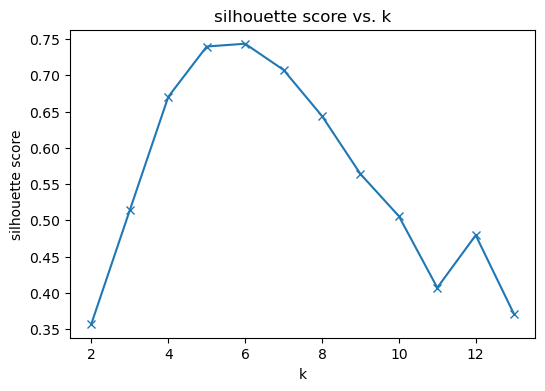

In [180]:
# plot clustering quality vs k
plt.figure(figsize=(6, 4))
plt.plot(K, sil_scores, marker='x')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.title('silhouette score vs. k')
plt.show()

#### Plot optimal clustering

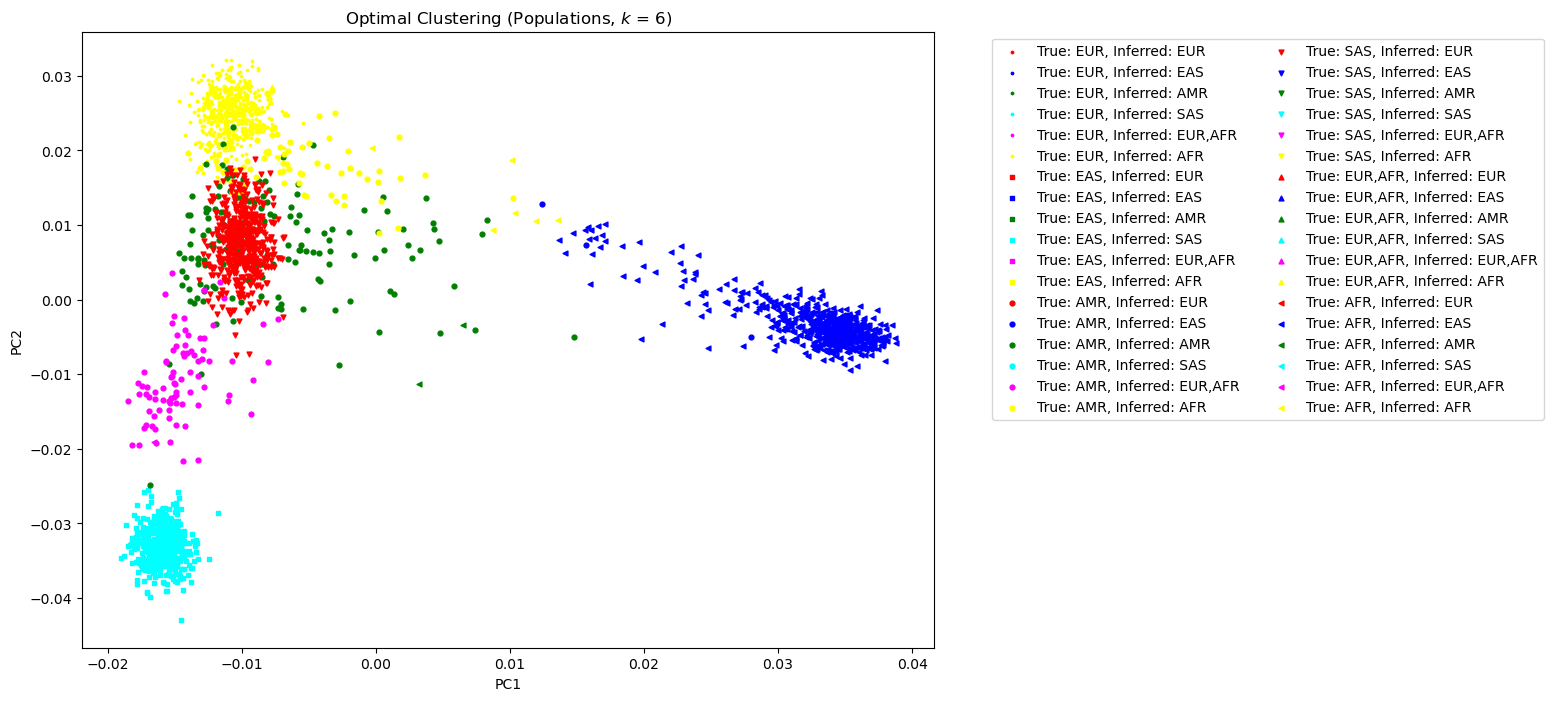

In [201]:
pca_data['inferred_assignment'] = kmeans_optimal.labels_
plt.figure(figsize=(11, 8))
plt.title(f'Optimal Clustering (Populations, $k$ = {optimal_k})')
plt.xlabel("PC1")
plt.ylabel("PC2")
for true_pop in pops_unique:
    for inferred_assignment in range(kmeans_optimal.labels_.max() + 1):
        # Select points that have true population = true_pop and inferred pop = inferred assignment
        mask = (pca_data['pop'] == true_pop) & (pca_data['inferred_assignment'] == inferred_assignment)

        #X has the same ordering as pca_data
        #we are naively selecting the first two coordinates because the first two PCs likely will dominate the coordinate variance
        selected_points = X[mask, :]
        
        # Plot selected points with the corresponding marker and color
        plt.scatter(selected_points[:, 0], selected_points[:, 1], s=12, marker=pop_shapes[true_pop], color=COLORS[inferred_assignment], label=f"True: {true_pop}, Inferred: {pops_unique[inferred_assignment]}")
plt.legend(bbox_to_anchor=(1.06, 1), loc='upper left', ncol=2)


### Does optimal $k$-means clustering capture subpopulation structure?

In [166]:
sil_scores_subpop = []
K = range(20, 30)
for k in K:
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=300, random_state=RAND_SEED)
    kmeans.fit(X)
    labels = kmeans.labels_
    sil_scores_subpop.append(silhouette_score(X, labels))

sil_scores_subpop = np.array(sil_scores_subpop)
optimal_k_subpop = K[np.argmax(sil_scores_subpop)]
kmeans_optimal_subpop = KMeans(n_clusters=optimal_k_subpop, init='k-means++', n_init=10, max_iter=300, random_state=RAND_SEED)
kmeans_optimal_subpop.fit(X)
print (f"optimal k: {optimal_k_subpop}; best silhouette score: {np.max(sil_scores_subpop)}")

optimal k: 20; best silhouette score: 0.7398222198278976


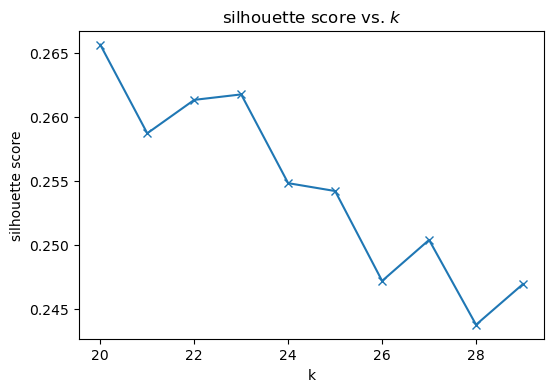

In [167]:
# plot clustering quality vs k
plt.figure(figsize=(6, 4))
plt.plot(K, sil_scores_subpop, marker='x')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.title('silhouette score vs. $k$')
plt.show()

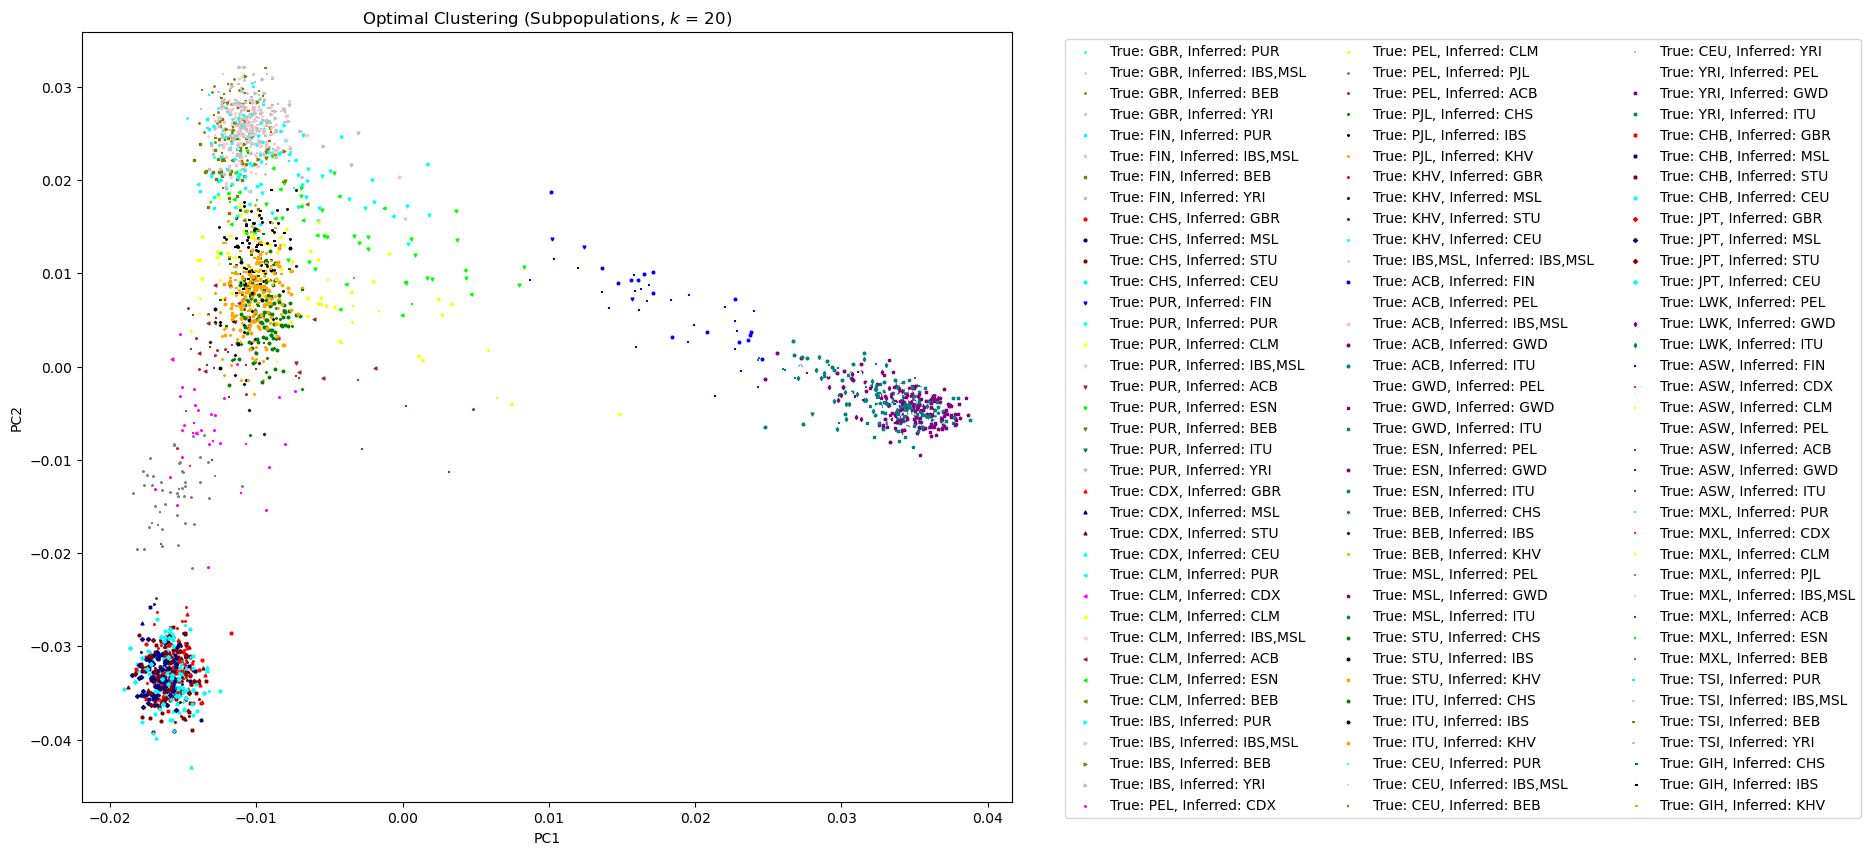

In [205]:

pca_data['inferred_assignment'] = kmeans_optimal_subpop.labels_
plt.figure(figsize=(12, 10))
plt.title(f'Optimal Clustering (Subpopulations, $k$ = {optimal_k_subpop})')
plt.xlabel("PC1")
plt.ylabel("PC2")
for true_subpop in subpops_unique:
    for inferred_assignment in range(kmeans_subpop.labels_.max() + 1):
        # Select points that have true population = true_pop and inferred pop = inferred assignment
        mask = (pca_data['subpop'] == true_subpop) & (pca_data['inferred_assignment'] == inferred_assignment)

        #X has the same ordering as pca_data
        #we are naively selecting the first two coordinates because the first two PCs likely will dominate the variation
        selected_points = X[mask, :]
        if selected_points.shape[0] == 0: continue
        # plot selected pts with the corresponding marker and color
        plt.scatter(selected_points[:, 0], selected_points[:, 1], s=4, marker=subpop_shapes[true_subpop], color=COLORS[inferred_assignment], label=f"True: {true_subpop}, Inferred: {subpops_unique[inferred_assignment]}")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=3)

##### Analysis

In [12]:
#what's the number of true subpopulations in our data?
num_pops = pca_data['pop'].unique().shape[0]
num_subpops = pca_data['subpop'].unique().shape[0]
num_pops, num_subpops

(6, 27)

We can see here that the silhouette score is highest when the number of clusters is equal to the true number of populations in the data. The silhouette score drops considerably when tuning to a number of clusters near the true number of subpopulations. One could argue that this indicates $k$-means clustering is not precise enough for such granularity. But the plot seems 

### Hierarchical Clustering

In [55]:
#for plotting inferred hierarchy.
#see https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

In [56]:
# do agglomerative clustering
agg_cluster = AgglomerativeClustering(metric='euclidean', linkage='ward')
labels_agg = agg_cluster.fit_predict(X)

Text(0.5, 1.0, 'Agglomerative Hierarchical Clustering')

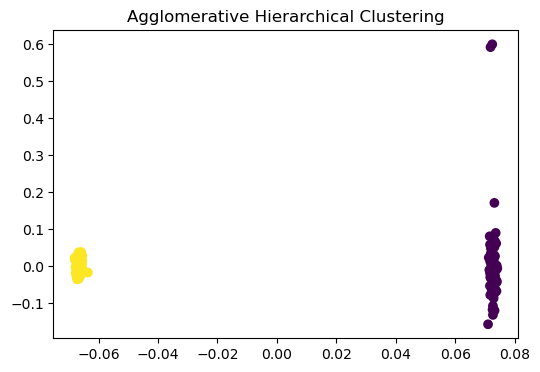

In [62]:
# results of agglomerative clustering
plt.figure(figsize=(6, 4))
plt.scatter(X[:, 0], X[:, 1], c=labels_agg, cmap='viridis')
plt.title("Agglomerative Hierarchical Clustering")
#plt.show()

In [59]:
# model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
# model = model.fit(X)

In [ ]:
# plt.title("Population Structure via Ward's Method")
# plot_dendrogram(model, truncate_mode="level", p=3)
# plt.xlabel("Number of points in node (or index of point if no parenthesis).")
# plt.show()